## Libraries

In [1]:
# linear algebra and data processing
import numpy as np
import pandas as pd 

#visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# math and statistics
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# ignnore warnings
import warnings
warnings.filterwarnings(action="ignore")

# data paths
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/test.csv
/kaggle/input/rossmann-store-sales/sample_submission.csv


## Data

In [2]:
# data
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')
test = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')
submission = pd.read_csv('/kaggle/input/rossmann-store-sales/sample_submission.csv')

print('train set shape:', train.shape)
print('test set shape:', test.shape)
print('store set shape:', store.shape)

train set shape: (1017209, 9)
test set shape: (41088, 8)
store set shape: (1115, 10)


In [3]:
# quick peak

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [5]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Not so much preprocessing required in the train and test sets. Nevertheless, the'll be joined with the stores df, so the preprocessing will be uniform.

In [6]:
# merge the train/test sets with the stores set
full_train = pd.merge(left = train, right = store, how = 'inner', left_on = 'Store', right_on = 'Store')
full_test = pd.merge(left = test, right = store, how = 'inner', left_on = 'Store', right_on = 'Store')
print(full_train.shape)
print(full_test.shape)

(1017209, 18)
(41088, 17)


## Preprocessing
* Handling null values
* General house keeping

**PS**: Categorical features are not encoded in this kernel since we wanna explore the relationships between the columns and not build models.  Numerical features aren't scaled either

In [7]:
full_train.isna().any()

Store                        False
DayOfWeek                    False
Date                         False
Sales                        False
Customers                    False
Open                         False
Promo                        False
StateHoliday                 False
SchoolHoliday                False
StoreType                    False
Assortment                   False
CompetitionDistance           True
CompetitionOpenSinceMonth     True
CompetitionOpenSinceYear      True
Promo2                       False
Promo2SinceWeek               True
Promo2SinceYear               True
PromoInterval                 True
dtype: bool

In [8]:
def preprocess_data(full_train, full_test):

    # dependent and independent variables
    global train_features, train_target, test_features
    train_features = full_train.drop(['Sales'], axis = 1) #drop the target feature + customers (~ will not be used for prediction)
    train_target  = full_train[['Sales']]
    test_features = full_test.drop(['Id'], axis = 1) #drop id, it's required only during submission
    test_features['Customers'] = 0
    
    #feature generation + transformations
    def feature_generation(data):
        data['Date'] = pd.to_datetime(data.Date)
        data['Month'] = data.Date.dt.month.to_list()
        data['Year'] = data.Date.dt.year.to_list()
        data['Day'] = data.Date.dt.day.to_list()
        data['WeekOfYear'] = data.Date.dt.weekofyear.to_list()
        data['DayOfWeek'] = data.Date.dt.dayofweek.to_list()
        data['weekday'] = 1        # Initialize the column with default value of 1
        data.loc[data['DayOfWeek'] == 5, 'weekday'] = 0
        data.loc[data['DayOfWeek'] == 6, 'weekday'] = 0
#         data = data.drop(['Date'], axis = 1)
        
        return data
    
    train_features = feature_generation(train_features)
    test_features = feature_generation(test_features)


    # numerical and categorical columns
    categorical = []
    numerical = []
    timestamp = []

    for col in train_features.columns:
        if train_features[col].dtype == object:
            categorical.append(col)
        elif train_features[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            numerical.append(col)
        else:
            timestamp.append(col)

    # Keep selected columns only
    my_cols = categorical + numerical + timestamp
    train_features = train_features[my_cols].copy()
    test_features = test_features[my_cols].copy()
    features = pd.concat([train_features, test_features]) #merge the features columns for uniform preprocessing

    # change dtypes for uniformity in preprocessing
    features.CompetitionOpenSinceMonth = features.CompetitionOpenSinceMonth.astype('Int64') 
    features.CompetitionOpenSinceYear = features.CompetitionOpenSinceYear.astype('Int64')
    features.Promo2SinceWeek = features.Promo2SinceWeek.astype('Int64') 
    features.Promo2SinceYear = features.Promo2SinceYear.astype('Int64')
    features["StateHoliday"].loc[features["StateHoliday"] == 0] = "0"
#     features = features.drop(['Store'], axis = 1)


    # ''' actual preprocessing: '''
    
    # null values
    # numerical null values
    for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
        features[col] = features[col].fillna((int(features[col].mean()))) 

    # categorical null values
    for col in ['Open', 'PromoInterval']:
        features[col] = features[col].fillna(features[col].mode()[0])
        
#     # categorical null values
#     features.PromoInterval = features.PromoInterval.fillna((features.PromoInterval.mode()))
#     features.Open = features.Open.fillna((features.Open.mode()))

    return features

In [9]:
features = preprocess_data(full_train, full_test)
print(features.shape)
features.head()

(1058297, 22)


,StateHoliday,StoreType,Assortment,PromoInterval,Store,DayOfWeek,Customers,Open,Promo,SchoolHoliday,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Year,Day,WeekOfYear,weekday,Date
0,0,c,a,"Jan,Apr,Jul,Oct",1,4,555,1.0,1,1,...,2008,0,23,2011,7,2015,31,31,1,2015-07-31
1,0,c,a,"Jan,Apr,Jul,Oct",1,3,546,1.0,1,1,...,2008,0,23,2011,7,2015,30,31,1,2015-07-30
2,0,c,a,"Jan,Apr,Jul,Oct",1,2,523,1.0,1,1,...,2008,0,23,2011,7,2015,29,31,1,2015-07-29
3,0,c,a,"Jan,Apr,Jul,Oct",1,1,560,1.0,1,1,...,2008,0,23,2011,7,2015,28,31,1,2015-07-28
4,0,c,a,"Jan,Apr,Jul,Oct",1,0,612,1.0,1,1,...,2008,0,23,2011,7,2015,27,31,1,2015-07-27


In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   StateHoliday               1058297 non-null  object        
 1   StoreType                  1058297 non-null  object        
 2   Assortment                 1058297 non-null  object        
 3   PromoInterval              1058297 non-null  object        
 4   Store                      1058297 non-null  int64         
 5   DayOfWeek                  1058297 non-null  int64         
 6   Customers                  1058297 non-null  int64         
 7   Open                       1058297 non-null  float64       
 8   Promo                      1058297 non-null  int64         
 9   SchoolHoliday              1058297 non-null  int64         
 10  CompetitionDistance        1058297 non-null  float64       
 11  CompetitionOpenSinceMonth  1058297 non-

All good now.

## Reconstruct Train and Test sets

In [11]:
train_feat = features.iloc[:len(train_features), ]
test_feat = features.iloc[len(train_features):, :]
train_set = train_feat.copy()
train_set['Sales'] = train_target
train_target.shape, train_feat.shape, train_set.shape, test_feat.shape

((1017209, 1), (1017209, 22), (1017209, 23), (41088, 22))

## Non-Graphical Analysis

In [12]:
train_set.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,2.998341,1.997391,0.0,1.0,3.0,5.0,6.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1017209.0,5430.049068,7705.297693,20.0,710.0,2330.0,6880.0,75860.0
CompetitionOpenSinceMonth,1017209.0,7.152022,2.654703,1.0,6.0,7.0,9.0,12.0
CompetitionOpenSinceYear,1017209.0,2008.470820,4.959791,1900.0,2008.0,2008.0,2011.0,2015.0
Promo2,1017209.0,0.500564,0.500000,0.0,0.0,1.0,1.0,1.0


## Graphical Analysis

#### Correlation

top 6 features with highest correlation with sales


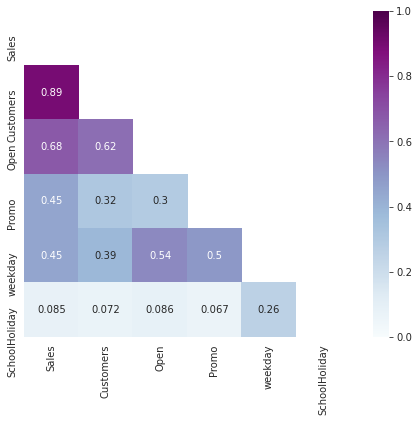

In [13]:
def correlation_map(f_data, f_feature, f_number):
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(8, 6))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

print('top 6 features with highest correlation with sales')
correlation_map(train_set, 'Sales', 6)

Sales and Customers have a high correlation. 
In the follow up plots, we'll explore how the 2 variables relate with the others.

#### StateHoliday

Text(0.5, 1.0, 'customers during Stateholidays')

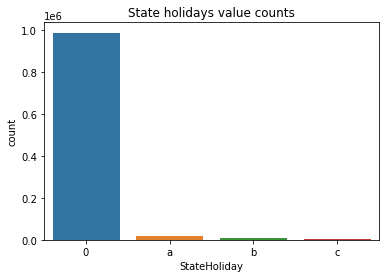

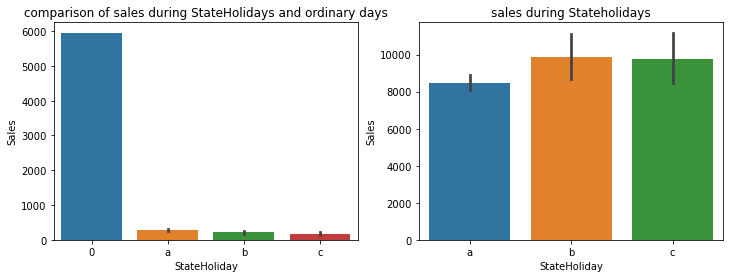

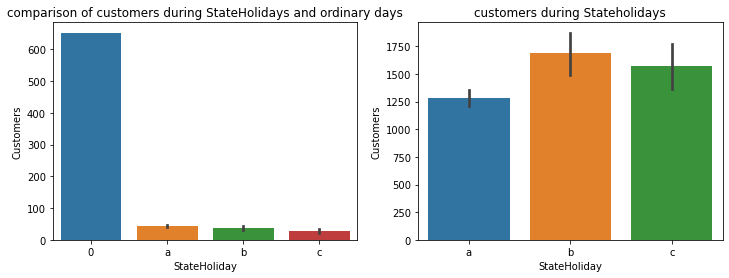

In [14]:
# state holiday + Sales + Customers

# merge '0' and 0
train_set["StateHoliday"].loc[train_set["StateHoliday"] == 0] = "0"
sns.countplot(x='StateHoliday', data=train_set).set_title('State holidays value counts')


# holidays + no_holidays
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,4))

sns.barplot(x='StateHoliday', y='Sales', data=train_set, ax=axis1).set_title('comparison of sales during StateHolidays and ordinary days')
# holidays only
mask = (train_set["StateHoliday"] != "0") & (train_set["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train_set[mask], ax=axis2).set_title('sales during Stateholidays')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,4))
sns.barplot(x='StateHoliday', y='Customers', data=train_set, ax=axis1).set_title('comparison of customers during StateHolidays and ordinary days')
# holidays only
mask = (train_set["StateHoliday"] != "0") & (train_set["Customers"] > 0)
sns.barplot(x='StateHoliday', y='Customers', data=train_set[mask], ax=axis2).set_title('customers during Stateholidays')

> 0 represents no holidays. Its counts are higher given that holidays are normally few.
> a reps public holiday, b - easter and c - christmas

#### StoreType

Text(0.5, 1.0, 'no of customers across diffrent StoreType')

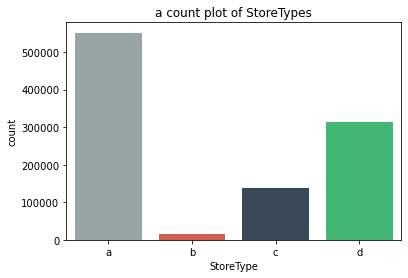

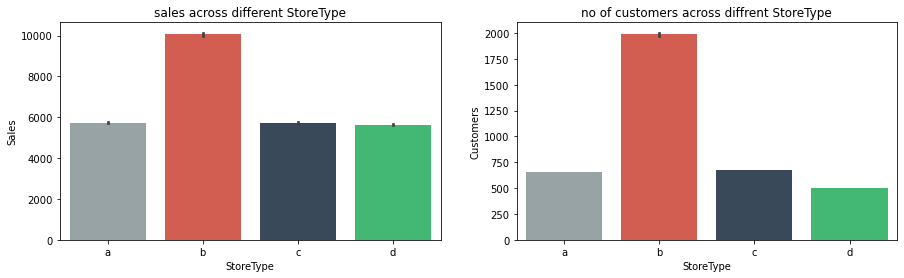

In [15]:
# store type
sns.countplot(x='StoreType', data=train_set, order=['a','b','c', 'd'], palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]).set_title('a count plot of StoreTypes')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='StoreType', y='Sales', data=train_set, ax=axis1, palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"], order=['a','b','c', 'd']).set_title('sales across different StoreType')
sns.barplot(x='StoreType', y='Customers', data=train_set, ax=axis2, palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"], order=['a','b','c', 'd']).set_title('no of customers across diffrent StoreType')

store type b is the least popular while a is the most popular. but b's sales are higher compared to the rest.

#### Assortment

Text(0.5, 1.0, 'customers across different assortment types')

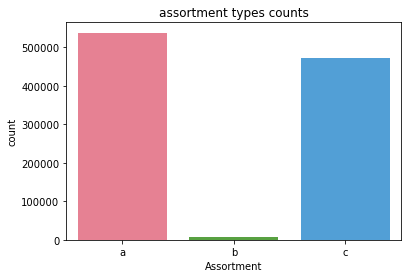

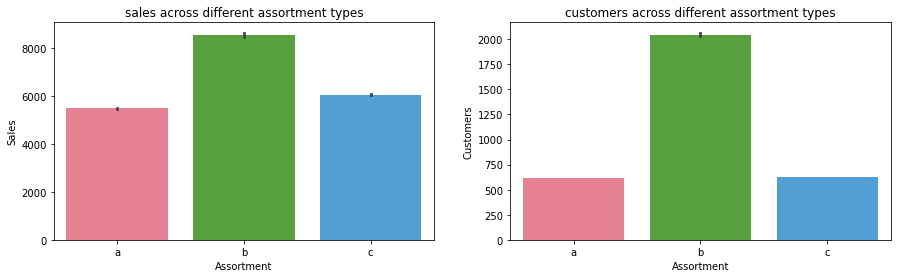

In [16]:
# assortment
sns.countplot(x='Assortment', data=train_set, order=['a','b','c'], palette = 'husl').set_title('assortment types counts')


fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Assortment', y='Sales', data=train_set, palette = 'husl', order=['a','b','c'], ax=axis1).set_title('sales across different assortment types')
sns.barplot(x='Assortment', y='Customers', data=train_set, palette = 'husl', order=['a','b','c'], ax=axis2).set_title('customers across different assortment types')

#### DayOfWeek + Open

Text(0.5, 1.0, 'customers across different days of the week ')

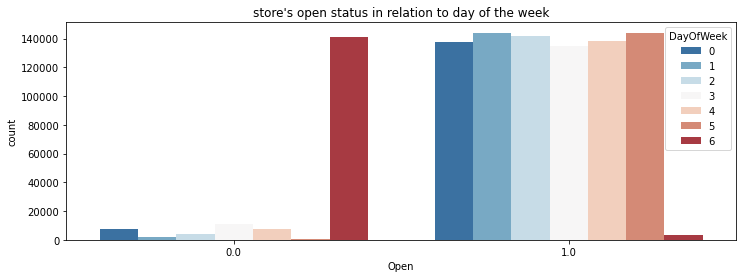

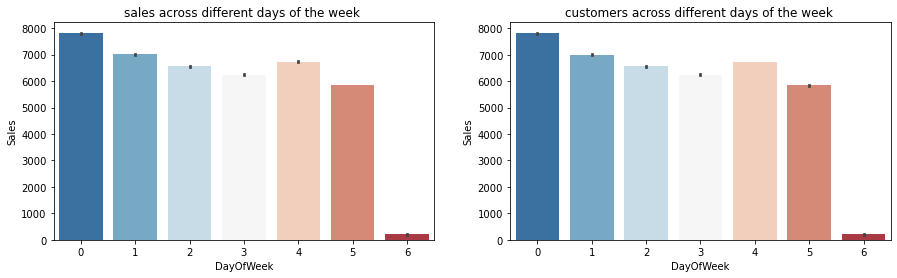

In [17]:
# dayofweek + open

#let's explore open in relation to day of week
fig, (axis1) = plt.subplots(1,1,figsize=(12,4))
sns.countplot(x='Open',hue='DayOfWeek', data=train_set, ax=axis1, palette = 'RdBu_r')
plt.title("store's open status in relation to day of the week")


# sales across dayofweek
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='DayOfWeek', y='Sales', data=train_set, palette = 'RdBu_r', ax=axis1).set_title('sales across different days of the week ')
sns.barplot(x='DayOfWeek', y='Sales', data=train_set, palette = 'RdBu_r', ax=axis2).set_title('customers across different days of the week ')


Most stores are open in the first 6 days and close on the 7th (Sunday).

The amount of sales and number of customers align with the trend across the week.

#### weekday

Text(0.5, 1.0, 'customers during weekends and weekdays')

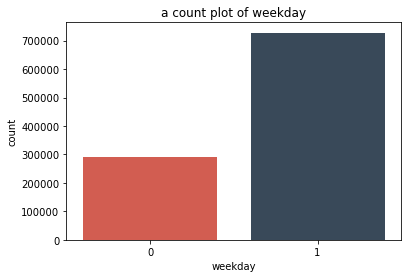

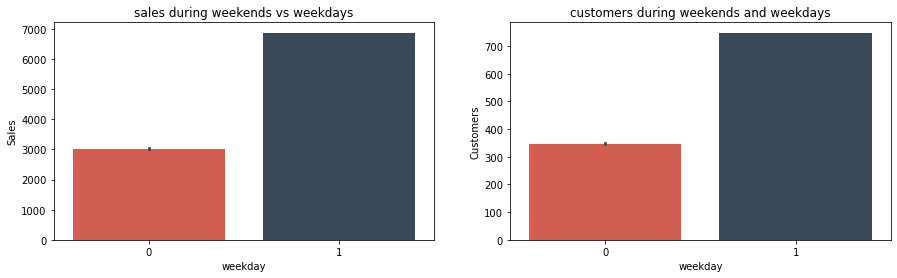

In [18]:
# weekday
flatui = [ "#e74c3c", "#34495e"]
sns.countplot(x='weekday', data=train_set, palette = flatui).set_title('a count plot of weekday')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='weekday', y='Sales', data=train_set, ax=axis1, palette = flatui).set_title('sales during weekends vs weekdays')
sns.barplot(x='weekday', y='Customers', data=train_set, ax=axis2, palette = flatui).set_title('customers during weekends and weekdays')

#### Promo

Text(0.5, 1.0, 'customers across different Promo')

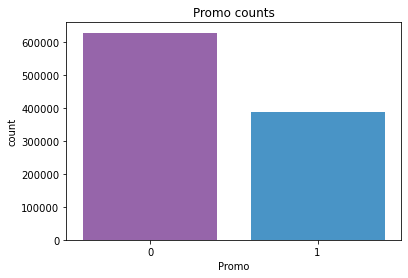

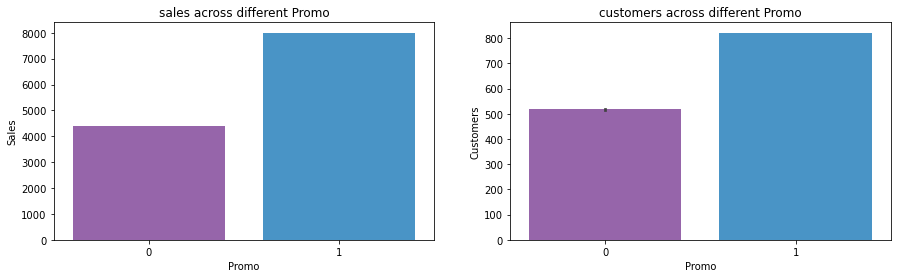

In [19]:
#Promo
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.countplot(x='Promo', data=train_set, palette = flatui).set_title('Promo counts')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo', y='Sales', data=train_set, palette = flatui, ax=axis1).set_title('sales across different Promo')
sns.barplot(x='Promo', y='Customers', data=train_set, ax=axis2,  palette = flatui).set_title('customers across different Promo')

Not most stores run daily promotions.
The sales and customers are higher in the less stores that run daily promotions

#### Promo2

Text(0.5, 1.0, 'customers across different Promo2')

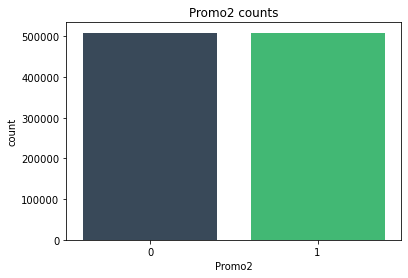

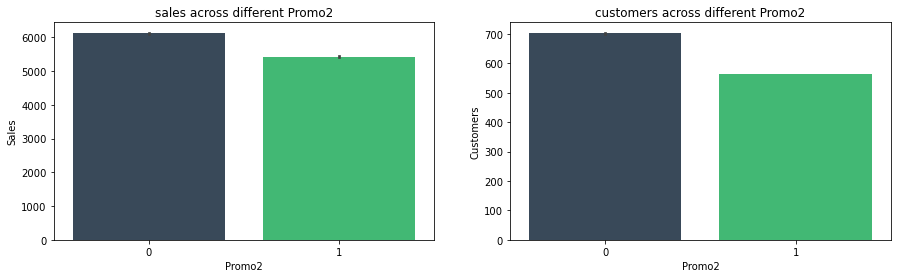

In [20]:
#Promo2
flatui = [ "#34495e", "#2ecc71"]

sns.countplot(x='Promo2', data=train_set, palette = flatui).set_title('Promo2 counts')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo2', y='Sales', data=train_set, ax=axis1, palette = flatui).set_title('sales across different Promo2')
sns.barplot(x='Promo2', y='Customers', data=train_set, ax=axis2, palette = flatui).set_title('customers across different Promo2')

there's a balance in the stores that run continous promotions. The sales and the customers in the promotion group is slightly lower.

#### PromoInterval

Text(0.5, 1.0, 'customers across different promo intervals')

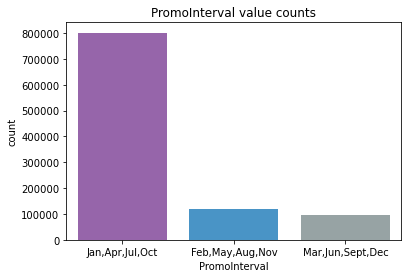

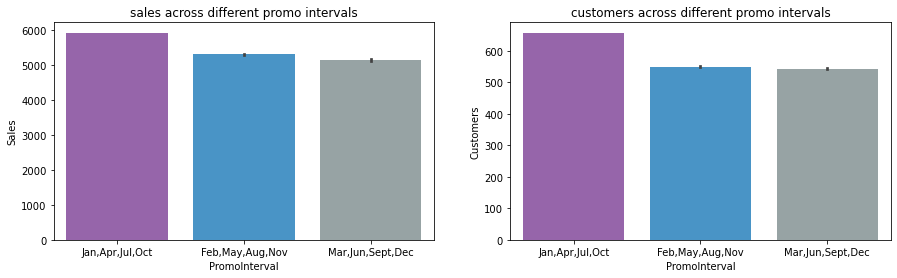

In [21]:
# PromoInterval
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.countplot(x='PromoInterval', data=train_set, palette = flatui).set_title('PromoInterval value counts')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='PromoInterval', y='Sales', data=train_set, ax=axis1, palette = flatui).set_title('sales across different promo intervals')
sns.barplot(x='PromoInterval', y='Customers', data=train_set, ax=axis2, palette = flatui).set_title('customers across different promo intervals')

#### SchoolHoliday

Text(0.5, 1.0, 'no of customers across ordinary school days and school holidays')

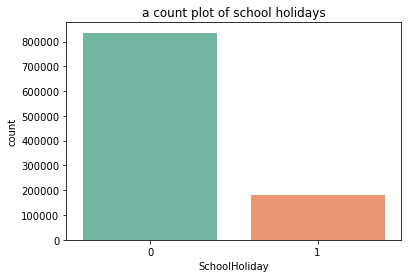

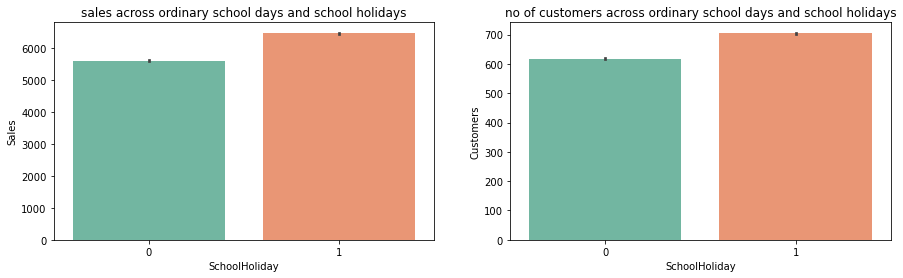

In [22]:
#SchoolHoliday
sns.countplot(x='SchoolHoliday', data=train_set, palette = 'Set2').set_title('a count plot of school holidays')

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=train_set, ax=axis1, palette = 'Set2').set_title('sales across ordinary school days and school holidays')
sns.barplot(x='SchoolHoliday', y='Customers', data=train_set, ax=axis2, palette = 'Set2').set_title('no of customers across ordinary school days and school holidays')

#### StateHoliday

Text(0.5, 1.0, 'sales during Stateholidays')

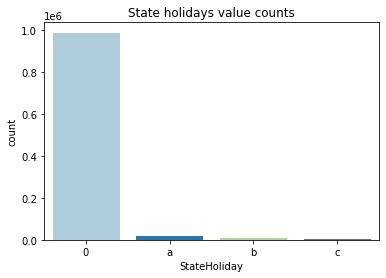

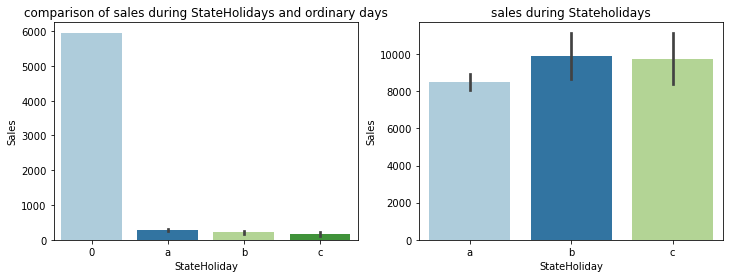

In [23]:
# stateholiday

# merge '0' and 0
train_set["StateHoliday"].loc[train_set["StateHoliday"] == 0] = "0"
# value counts
sns.countplot(x='StateHoliday', data=train_set, palette = 'Paired').set_title('State holidays value counts')

# holidays + no_holidays
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,4))
sns.barplot(x='StateHoliday', y='Sales', data=train_set, ax=axis1, palette = 'Paired').set_title('comparison of sales during StateHolidays and ordinary days')
# holidays only
mask = (train_set["StateHoliday"] != "0") & (train_set["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train_set[mask], ax=axis2, palette = 'Paired').set_title('sales during Stateholidays')

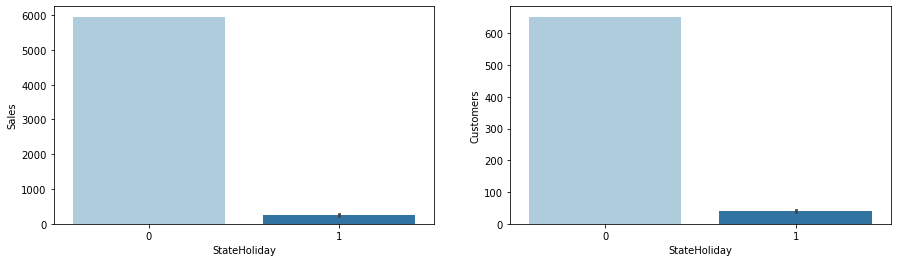

In [24]:
# observing all the holidays as one
train_set["StateHoliday"] = train_set["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
# test_df["StateHoliday"]     = test_df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='StateHoliday', y='Sales', data=train_set, ax=axis1, palette = 'Paired')
sns.barplot(x='StateHoliday', y='Customers', data=train_set, ax=axis2, palette = 'Paired')

#### CompetitionDistance

Text(0.5, 1.0, 'A piechart indicating mean number of customers in the 5 CompetitioDistance decile classes')

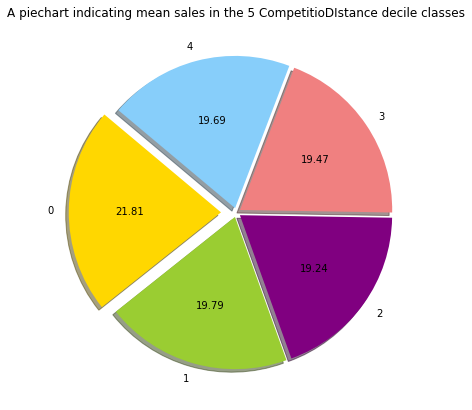

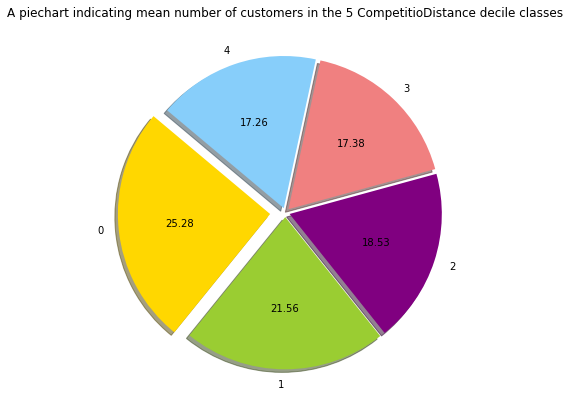

In [25]:
# competition distance +Sales + Customers

# adding Decile_rank column to the DataFrame 
train_set['Decile_rank'] = pd.qcut(train_set['CompetitionDistance'], 5, labels = False) 
new_df = train_set[['Decile_rank', 'Sales']]
# a = new_df.groupby('Decile_rank').sum()
a = new_df.groupby('Decile_rank').mean()
labels = a.index.to_list()
sizes = a.Sales.to_list()
fig = plt.figure(figsize =(10, 7)) 
colors = ['gold', 'yellowgreen', 'purple', 'lightcoral', 'lightskyblue']
explode = (0.1, 0.03, 0.03, 0.03, 0.03)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, shadow=True, autopct='%.2f', startangle=140)
plt.title('A piechart indicating mean sales in the 5 CompetitioDIstance decile classes')


# adding Decile_rank column to the DataFrame 
train_set['Decile_rank'] = pd.qcut(train_set['CompetitionDistance'], 5, labels = False) 
new_df = train_set[['Decile_rank', 'Customers']]
# a = new_df.groupby('Decile_rank').sum()
a = new_df.groupby('Decile_rank').mean()
labels = a.index.to_list()
sizes = a.Customers.to_list()
fig = plt.figure(figsize =(10, 7)) 
colors = ['gold', 'yellowgreen', 'purple', 'lightcoral', 'lightskyblue']
explode = (0.1, 0.03, 0.03, 0.03, 0.03)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, shadow=True, autopct='%.2f', startangle=140)
plt.title('A piechart indicating mean number of customers in the 5 CompetitioDistance decile classes')

The length of competition distances increase with decile classes. The total number of sales across the decile classes is somewhat balanced, apart from the first class which has a bit higher values compared to the rest. We expect it to have a lower volume considering the competition aspect but another argument that could explain the opposite behavior is the stores location. They could be located in big cities where population is dense thus proximity to competitive stores has a minor influence.

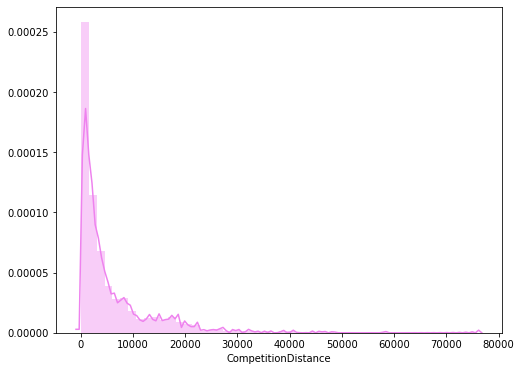

In [26]:
#CompetitionDistance
plt.figure(figsize = (8,6))
sns.distplot(train_set.CompetitionDistance, color = 'violet')

Most of the stores are closely spaced.

#### Date (Day/Week/Month/Year ~ Seasonality)

In [27]:
# Seasonality
#Date train
'''Data is from Jan 2013 to July 2015'''
time_data = train_set[['Date', 'Sales']]
time_data['datetime'] = pd.to_datetime(time_data['Date'])
time_data = time_data.set_index('datetime')
time_data = time_data.drop(['Date'], axis = 1)

<Figure size 864x360 with 0 Axes>

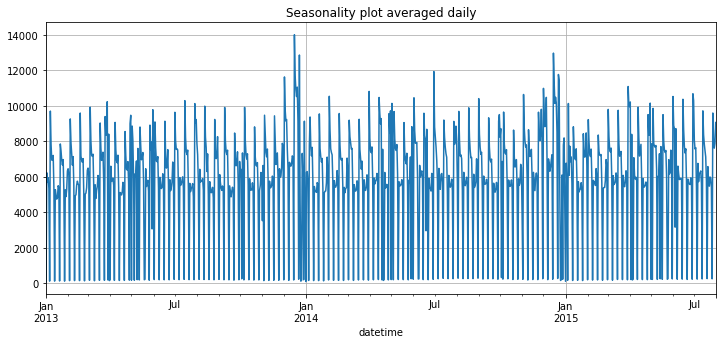

In [28]:
# daily train
daily_time_data = time_data.Sales.resample('D').mean() 
plt.figure(figsize = (12,5))
plt.figure(figsize = (12,5))
plt.title('Seasonality plot averaged daily')
daily_time_data.plot()
plt.grid()

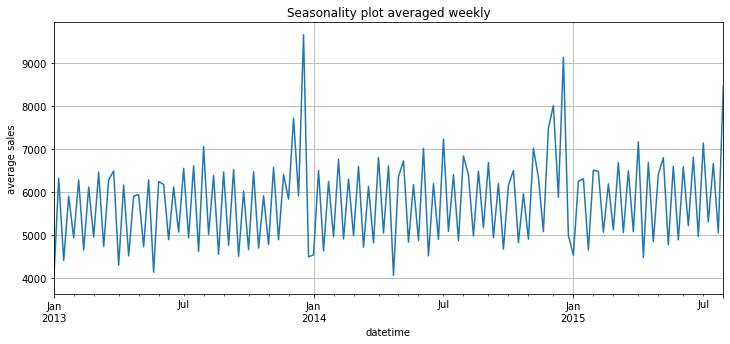

In [29]:
# weekly train
weekly_time_data = time_data.Sales.resample('W').mean() 
plt.figure(figsize = (12,5))
plt.title('Seasonality plot averaged weekly')
plt.ylabel('average sales')
weekly_time_data.plot()
plt.grid()

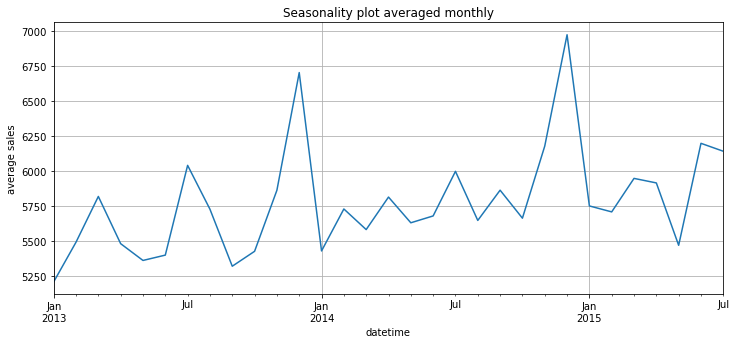

In [30]:
# Monthly train
monthly_time_data = time_data.Sales.resample('M').mean() 
plt.figure(figsize = (12,5))
plt.title('Seasonality plot averaged monthly')
plt.ylabel('average sales')
monthly_time_data.plot()
plt.grid()

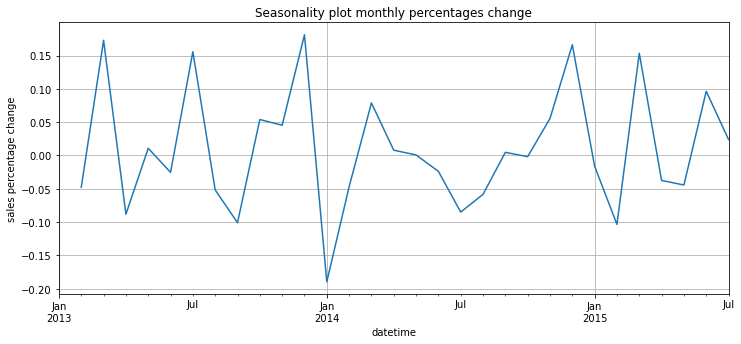

In [31]:
# Monthly percentage
monthly_time_data = time_data.Sales.resample('M').sum().pct_change()
plt.figure(figsize = (12,5))
plt.title('Seasonality plot monthly percentages change')
plt.ylabel('sales percentage change')
monthly_time_data.plot()
# pct_change_sales = rossmann_df.groupby('Date')["Sales"].sum().pct_change()
plt.grid()

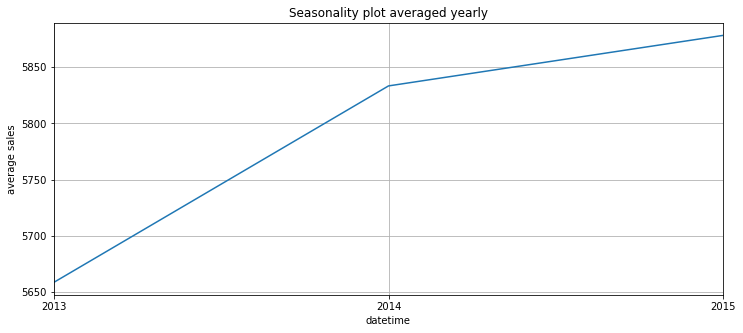

In [32]:
# yearly train
yearly_time_data = time_data.Sales.resample('Y').mean() 
plt.figure(figsize = (12,5))
plt.title('Seasonality plot averaged yearly')
plt.ylabel('average sales')
yearly_time_data.plot()
plt.grid()

Seasonality plots averaged weekly and monthly


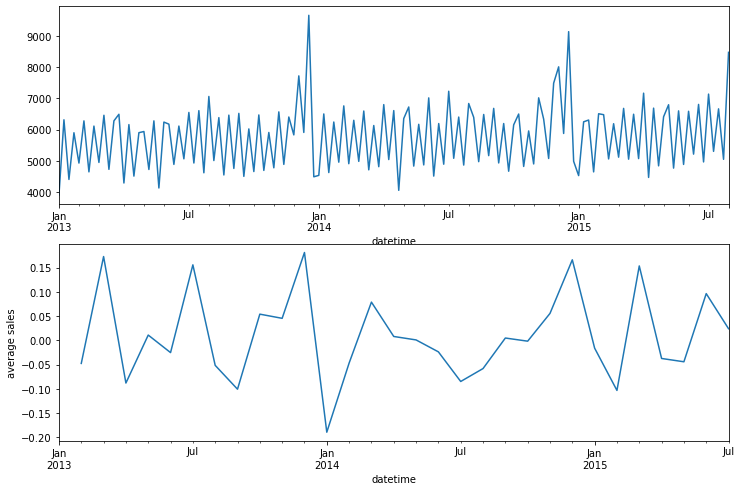

In [33]:
f, axs = plt.subplots(2,figsize=(12,8))
plt.ylabel('average sales')
# daily_time_data.plot(ax = axs[0])
weekly_time_data.plot(ax=axs[0])
monthly_time_data.plot(ax=axs[1])
print('Seasonality plots averaged weekly and monthly')

#### Sales

[Text(0.5, 1.0, 'sales distribution')]

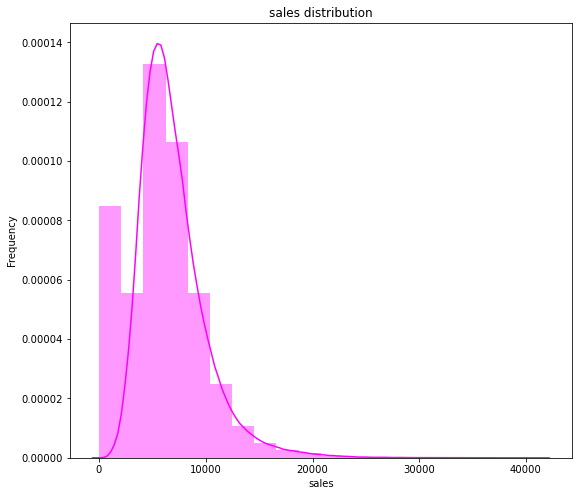

In [34]:
#sales

'''The target variable'''
f, ax = plt.subplots(figsize=(9, 8))
sns.distplot(train_set['Sales'], bins = 20, color = 'Magenta')
ax.set(ylabel="Frequency")
ax.set(xlabel="sales")
ax.set(title="sales distribution")